# Исследование убытков развлекательного приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.  
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Цель исследования:**
1. Изучить окупаемость рекламных кампаний по всем каналам привлечения в разных странах и на разных устройствах.
2. Выделить причины неэффективности привлечения пользователей.
3. Сформулировать рекомендации для отдела маркетинга.

**Ход исследования:**
В моем распоряжении три датасета. Файл с информацией о посещениях сайта, файл с информацией о заказах, а также информация о расходах на рекламу.

Я загружу данные, проверю на наличие пропусков и дубликатов. Изменю тип данных в столбцах, где это необходимо. Затем я напишу функции для расчета и анализа LTV, ROI, удержания и конверсии. Проведу исследовательский и маркетинговый анализ, после чего оценю окупаемость рекламы. Выявлю убыточные регионы, устройства или рекламные каналы и изучу их подробнее.

Таким образом, мое исследование состоит из 6 этапов:
1. Предобработка данных.
2. Написание функций для расчета и анализа.
3. Исследовательский анализ данных.
4. Маркетинг.
5. Оценка окупаемости рекламы.
6. Написание общего вывода.

### Предобработка данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные
visits = pd.read_csv('C:/Users/user/anaconda3/datasets/visits_info_short.csv')
orders = pd.read_csv('C:/Users/user/anaconda3/datasets/orders_info_short.csv')
ad_costs = pd.read_csv('C:/Users/user/anaconda3/datasets/costs_info_short.csv')

In [3]:
# Посмотрим информацию о датафреймах
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропуски во всех датафреймах отсутствуют. Необходимо привести названия столбцов к общему виду для удобства работы с данными. 

In [6]:
# Изменим названия столбцов во всех датафреймах
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
ad_costs.columns = [x.lower().replace(' ', '_') for x in ad_costs.columns.values]

In [7]:
# Проверим данные на наличие дубликатов
print('Количество явных дубликатов в visits: {}'.format(visits.duplicated().sum()))
print('Количество явных дубликатов в orders: {}'.format(orders.duplicated().sum()))
print('Количество явных дубликатов в ad_costs: {}'.format(ad_costs.duplicated().sum()))

Количество явных дубликатов в visits: 0
Количество явных дубликатов в orders: 0
Количество явных дубликатов в ad_costs: 0


Явных дубликатов в данных нет. Изменим тип данных в столбцах, где это необходимо.

In [8]:
# visits
# Столбцы session_start и session_end необходимо привести к типу datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [9]:
# orders
# Столбец event_dt необходимо привести к типу datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
# ad_costs
# Столбец dt необходимо привести к типу datetime
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

Изучим данные более детально, чтобы проверить их на соответствие условиям проекта, на наличие ошибок или аномалий.

In [11]:
# Изучим датафрейм visits
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [12]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [13]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [14]:
# Проверим не было ли окончания сесси раньше, чем начало
error_count = 0
for index in range(len(visits)):
    session_duration = timedelta.total_seconds(
        visits.loc[index, 'session_end'] -  visits.loc[index, 'session_start'])
    if session_duration < 0:
        error_count +=1
print('Количество отрицательных значений: {}'.format(error_count))

Количество отрицательных значений: 0


В датафрейме `visits` не найдено ошибок или аномалий. Соответствие данных временным условиям проекта проверим после формирования профилей пользователей.

In [15]:
# Изучим датафрейм visits
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

В датафрейме `orders` также не выявлено ошибок или аномалий.

In [16]:
# Изучим датафрейм ad_costs
ad_costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [17]:
ad_costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

В датафрейме `ad_costs` также не выявлено ошибок или аномалий. 

**Вывод**: В исходных данных отсутсвуют пропуски, дубликаты, ошибки или аномалии. Данных достаточно для проведения достоверного исследования.

### Написание функций для расчета и анализа

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [18]:
# Зададим функцию для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):
    
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles


In [19]:
# Зададим функцию для подсчёта Retention Rate
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
     # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# Зададим функцию для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
# Создадим функцию для подсчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 


In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

#### Минимальная и максимальная даты привлечения пользователей

In [26]:
# Составим профили пользователей
profiles = get_profiles(visits, orders, ad_costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [28]:
profiles['dt'].max()

datetime.date(2019, 10, 27)

**Вывод:** Минимальная дата привлечения пользователей - 1 мая 2019 года, максимальная дата - 27 октября 2019 года, что соответствует ТЗ исследования.

#### Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

In [29]:
users_region = profiles.groupby('region').agg({'payer': ['count', 'sum', 'mean']})
users_region.columns = ['users_count', 'paying_users', 'propotion']
users_region['propotion'] = round(users_region['propotion'] * 100, 2) # Переведем в %
users_region.sort_values(by='paying_users', ascending=False)

,users_count,paying_users,propotion
region,,,
United States,100002,6902,6.90
UK,17575,700,3.98
France,17450,663,3.80
Germany,14981,616,4.11


**Вывод:** Пользователи приходят из таких стран, как США, Великобритания, Германия и Франция. Больше всего платящих пользователей приходит из США (6902 - около 7% от всех пользователей США).

#### Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи

In [30]:
users_device = profiles.groupby('device').agg({'payer': ['count', 'sum', 'mean']})
users_device.columns = ['users_count', 'paying_users', 'propotion']
users_device.sort_values(by='propotion', ascending=False)

,users_count,paying_users,propotion
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


**Вывод:** Клиенты пользуются такими устройствами, как iPhone, Mac, PC, устройства на Android. Платящие пользователи предпочитают платформы Mac и iPhone.

#### Каналы, из которых пришло больше всего платящих пользователей

In [31]:
users_channel = profiles.groupby('channel').agg({'payer': ['count', 'sum', 'mean']})
users_channel.columns = ['users_count', 'paying_users', 'propotion']
users_channel.sort_values(by='paying_users', ascending=False)

,users_count,paying_users,propotion
channel,,,
FaceBoom,29144,3557,0.122049
TipTop,19561,1878,0.096007
organic,56439,1160,0.020553
WahooNetBanner,8553,453,0.052964
AdNonSense,3880,440,0.113402
RocketSuperAds,4448,352,0.079137
LeapBob,8553,262,0.030633
OppleCreativeMedia,8605,233,0.027077
lambdaMediaAds,2149,225,0.104700


**Вывод:** В результате выполненного раздела мы выяснили, что временные рамки соответствуют ТЗ проекта. Больше всего платящих пользователей приходит из США (6902 чел). Также мы знаем, что платящие пользователи предпочитают платформы Mac и iPhone. При этом больше всего платящих пользователей пришло с канала FaceBoom (3557 чел), на втором месте - TipTop (привлек в 2 раза меньше).

### Маркетинг

#### Общая сумма расходов на маркетинг

In [32]:
ad_costs['costs'].sum().round(1)

105497.3

**Вывод:** Общая сумма расходов на маркетинг составила 105 497 условных единиц.

#### Распределение трат по рекламным источникам

In [33]:
costs_channel = (
    ad_costs.pivot_table(index='channel', values='costs', aggfunc='sum')
    .sort_values(by='costs', ascending=False)
    .reset_index()
)
costs_channel['percent'] = round(costs_channel['costs']/sum(costs_channel['costs'])*100, 1)
costs_channel

,channel,costs,percent
0,TipTop,54751.30,51.9
1,FaceBoom,32445.60,30.8
2,WahooNetBanner,5151.00,4.9
3,AdNonSense,3911.25,3.7
4,OppleCreativeMedia,2151.25,2.0
5,RocketSuperAds,1833.00,1.7
6,LeapBob,1797.60,1.7
7,lambdaMediaAds,1557.60,1.5
8,MediaTornado,954.48,0.9
9,YRabbit,944.22,0.9


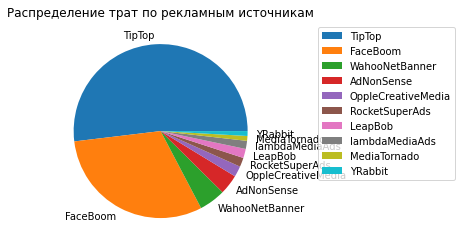

In [34]:
plt.figure()
plt.pie(costs_channel['percent'], labels=costs_channel['channel'])
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1.0))
plt.title('Распределение трат по рекламным источникам')
plt.show()

**Вывод:** Больше всего денег потратили на `TipTop` (54 751). На втором месте - `FaceBoom`, почти в два раза меньше (32 446).

#### Динамика изменения расходов во времени

In [35]:
# Копируем датафрейм и внесем столбец с неделями, необходимый для изучения динамики расходов
ad_costs_1 = ad_costs.copy()
ad_costs_1['week'] = ad_costs_1['dt'].astype('datetime64[W]')
# Удалим недели, которые не полностью попали в промежуток от 1 мая до 27 октября 2019 года
min_date = ad_costs_1['dt'].min()
max_date = ad_costs_1['dt'].max()
ad_costs_1 = ad_costs_1.query('week >= @min_date and week <= @max_date')

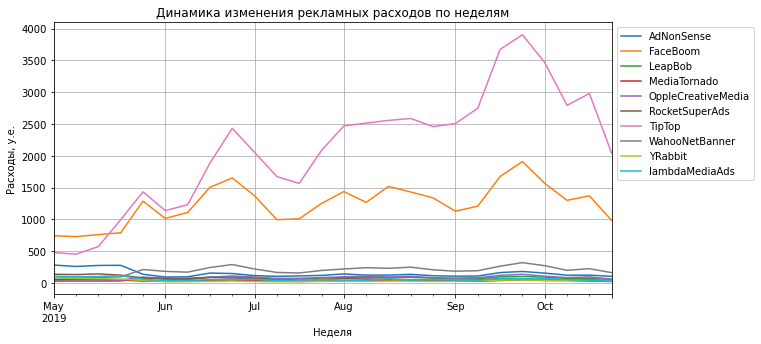

In [36]:

(
    ad_costs_1.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(figsize=(10,5))
)
plt.grid()
plt.title('Динамика изменения рекламных расходов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы, у.е.')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

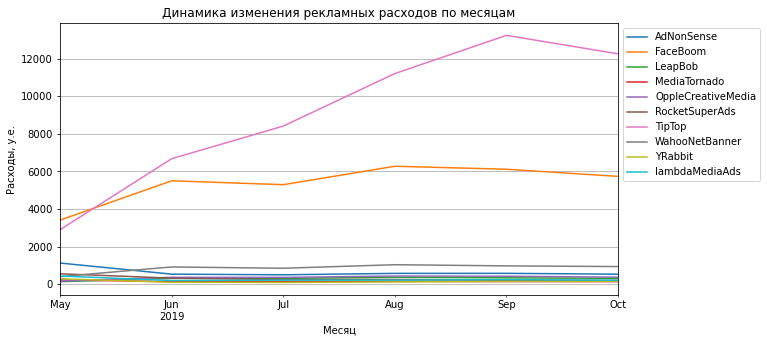

In [37]:
# Визуализируем динамику расходов по каналам по месяцам
ad_costs_1['month'] = ad_costs_1['dt'].astype('datetime64[M]')

(
    ad_costs_1.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot(figsize=(10,5))
)
plt.grid()
plt.title('Динамика изменения рекламных расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы, у.е.')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

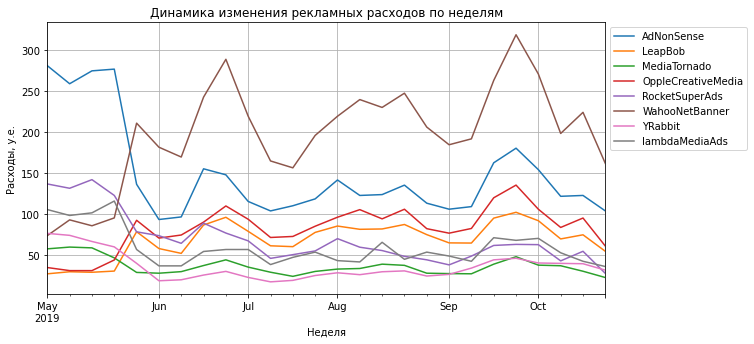

In [38]:
# Посмотрим на динамику подробнее, убрав две самые эффективные плафтормы
(
    ad_costs_1.query('channel not in ["FaceBoom", "TipTop"]')
    .pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(figsize=(10,5))
)
plt.grid()
plt.title('Динамика изменения рекламных расходов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы, у.е.')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

**Вывод:** Исходя из динамики изменения расходов во времени можно сказать, траты на рекламу по всем каналам резко возросли в 3 неделю июня и в 3 неделю сентября. Наблюдается стремительный рост трат на рекламу с мая до  конца октября по каналу - `TipTop`.                                  

#### CAC

In [39]:
profiles = get_profiles(visits, orders, ad_costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [40]:
(
    profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
    .sort_values('acquisition_cost', ascending=False)
    .round(2)
)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


In [44]:
round(profiles['acquisition_cost'].mean(), 1)

0.7

Средний CAC по проекту составил 0.7 условных единиц.

**Вывод:** Можно сказать, что самый дорогой истоник - `TipTop`. Привлечение одного пользователя здесь стоит в 4 раза дороже среднего CAC по всем каналам. Дешевле всего привлечение одного пользователя у таких каналов, как `YRabbit`, `MediaTornado`, `LeapBob` (0.2 у.е.).

**Общий вывод:** В результате выполненного раздела, мы выяснили, что общая сумма расходов на маркетинг составила 105 497 у.е. Больше всего денег потратили на TipTop (54 751 у.е.). На втором месте - FaceBoom, почти в два раза меньше (32 446 у.е.). Исходя из динамики изменения расходов во времени можно сказать, траты на рекламу с начала мая по конец октября резко возросли по каналу - TipTop. Средний CAC по проекту составил 0.7 у.е. При этом самый дорогой истоник - TipTop. Привлечение одного пользователя здесь стоит в 4 раза дороже среднего CAC по всем каналам.  
Можно сделать вывод, что наиболее дорогостоящим каналом привлечения пользователей является TipTop, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop'a и, соответственно, не очень высокой их платежеспособностью.

### Окупаемость рекламы

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.  
Органических пользователей следует исключить из анализа, так как они пришли сами и затраты на их привлечение равны нулю.

In [45]:
profiles = profiles.query('channel != "organic"')

In [46]:
# Посчитаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=[], )

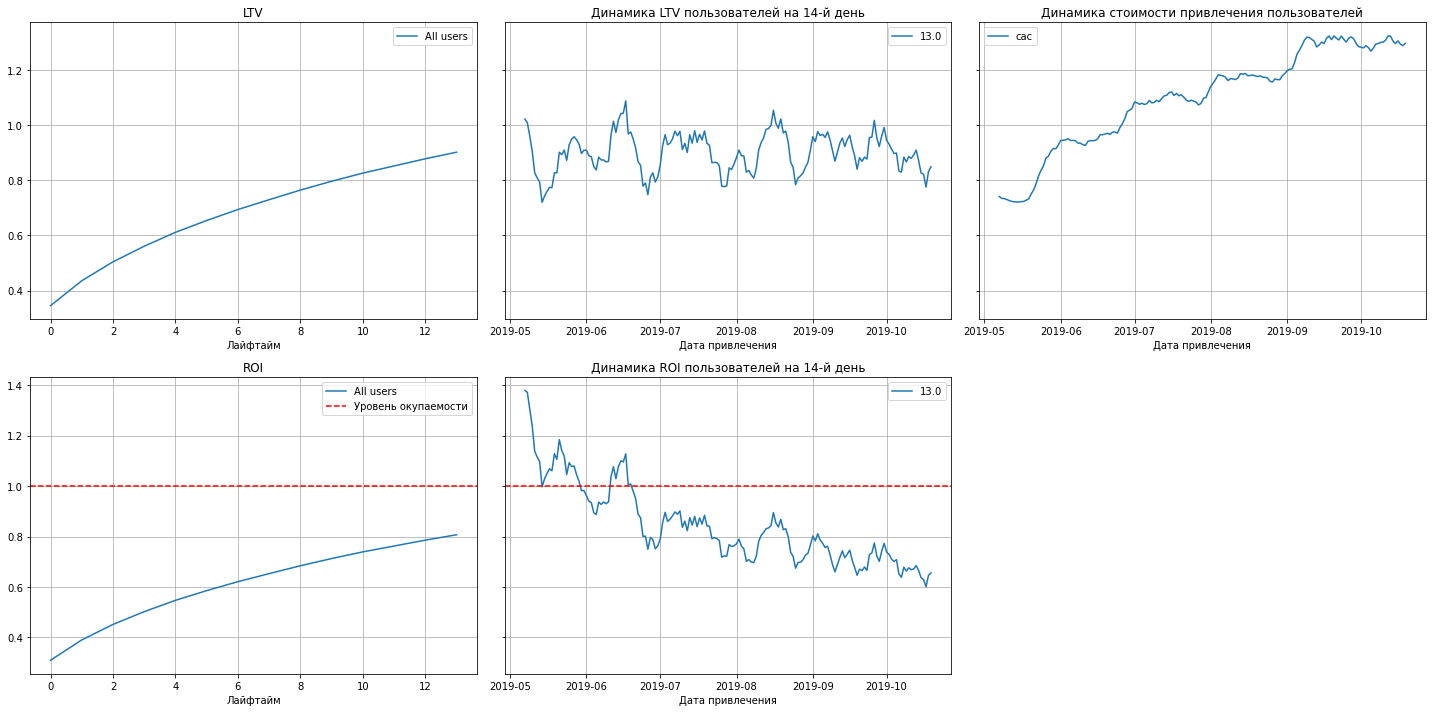

In [47]:
# Визуализиурем LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

In [48]:
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


**Вывод:** Можно сказать, что пользователи не окупаются за две недели. На 14-й день LTV составил 80% от CAC. Однако график динамики ROI показывает, что реклама стабильно окупалась в мае и в середине июня.  
Наблюдается тренд снижения окупаемости в эти 6 месяцев. Объяснить это можно тем, что LTV в течение 6 месяцев остается примерно на том же уровне, а стоимость привлечения пользователей заметно выросла.

#### Конверсия и удержание пользователей

In [49]:
# Посчитаем удержание
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14,)
retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,81334,1.0,0.176876,0.086594,0.051823,0.033504,0.024701,0.018651,0.014188,0.011729,0.009541,0.007488,0.006393,0.006012,0.004709
True,7310,1.0,0.380985,0.293023,0.235568,0.210260,0.191245,0.166758,0.156908,0.145144,0.136389,0.135021,0.121888,0.118741,0.104925


In [50]:
# Посчитаем конверсию
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14,)
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.058752,0.066321,0.069999,0.072571,0.0745,0.075775,0.076745,0.077591,0.078291,0.078945,0.079362,0.079678,0.079904,0.080197


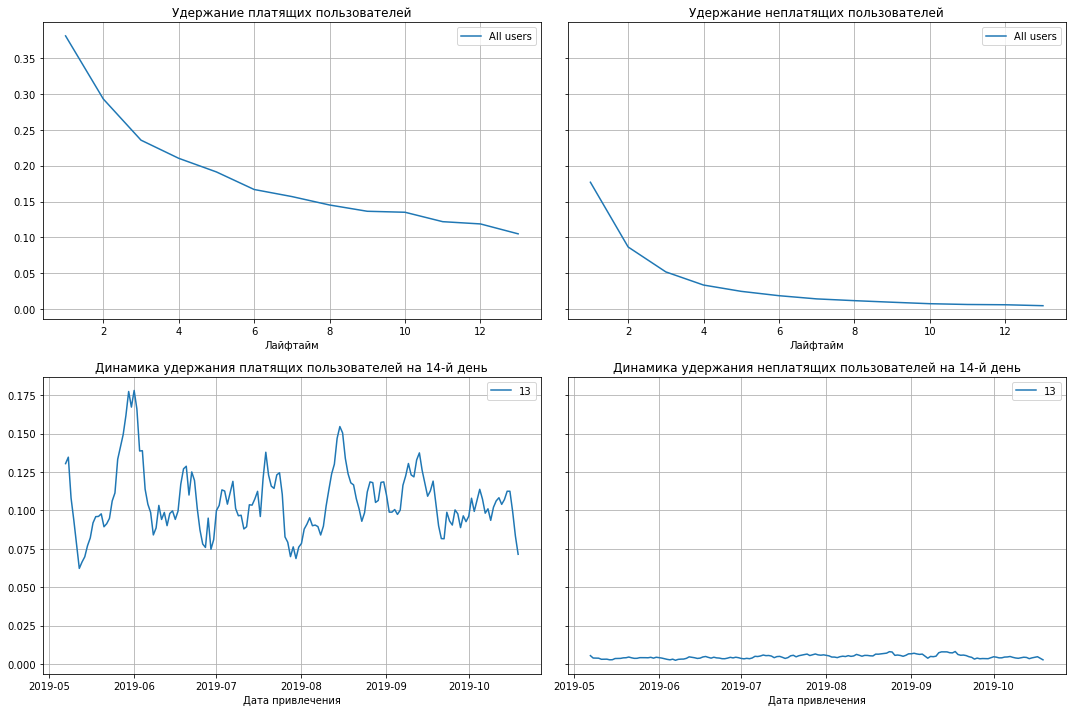

In [51]:
plot_retention(retention, retention_history, 14, window=7)

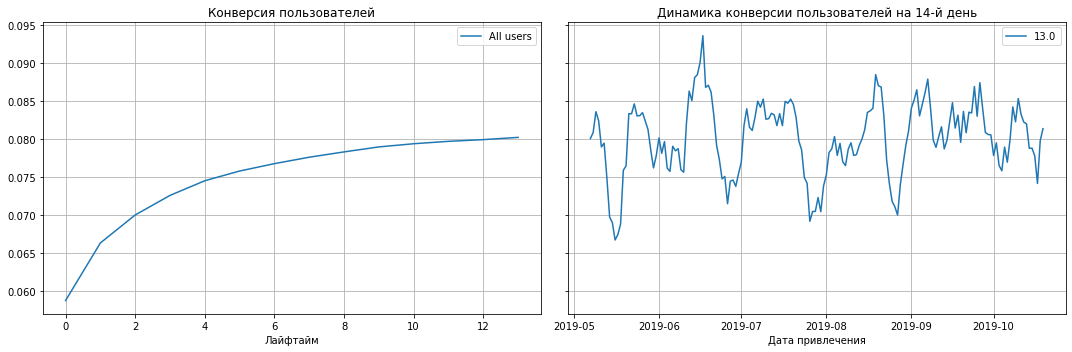

In [52]:
plot_conversion(conversion, conversion_history, 14, window=7)

**Вывод:** Удержание платящих пользователей на 14 день составило 10%, что не является критически низким показателем. Исходя из динамики удержания можно сказать, что на протяжении 6 месяцев наблюдаются колебания от 7% до 18%. В конце мая - начале июня пришли самые качественные пользователи.
Тенденций спада или роста удержания в течени полугода не наблюдается.  
Конверсия на 14-й день составляет 8%, то есть около 8% от всех привлеченных совершают покупку в течении 14 дней, что также неплохой результат. Динамика конверсии в течении полугода колеблется от 6,5% до 9,5%.

#### Окупаемость рекламы с разбивкой по устройствам

In [53]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'], )

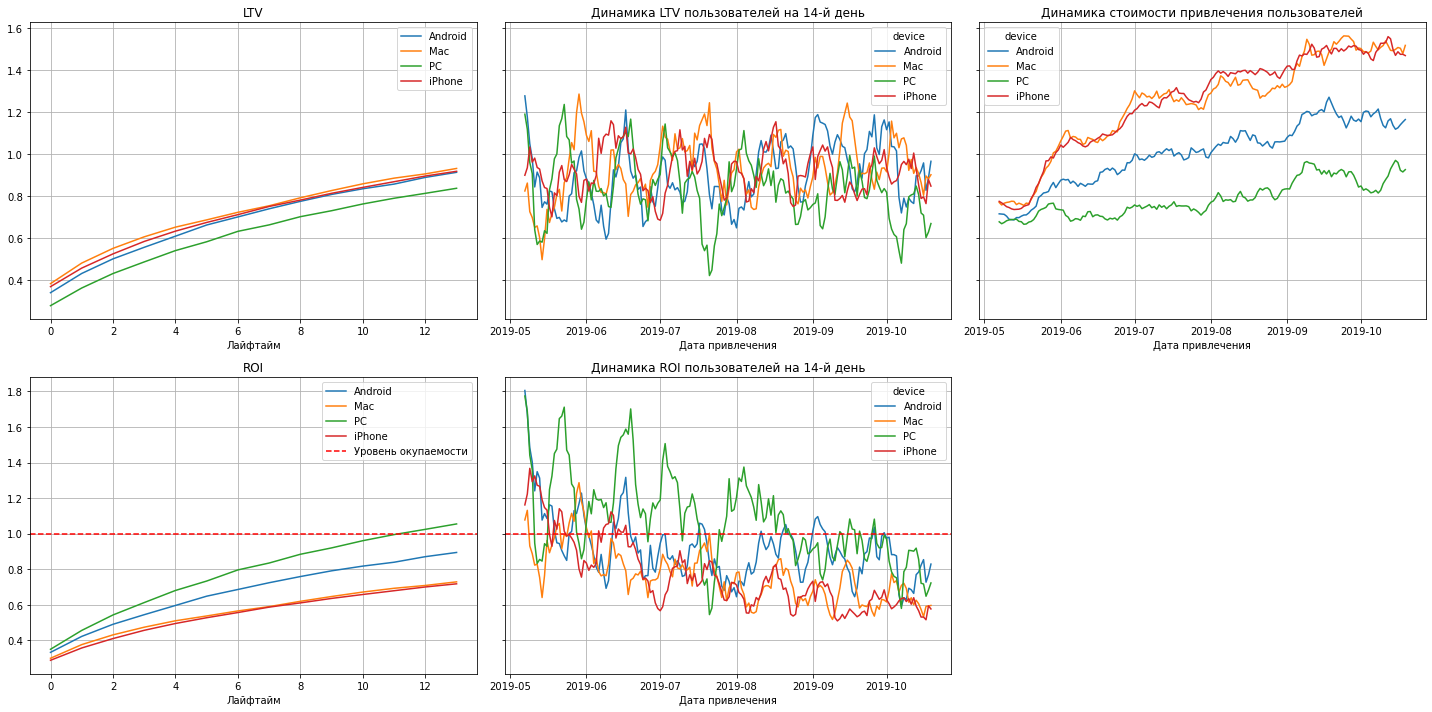

In [54]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Вывод:** Реклама окупается на 14 день только у пользователей на ПК. Можно объяснить самой низкой стоимостью привлечения таких пользователей. Пользователи остальных устройств не окупаются. Стоимость привлечения пользователей iPhone и Mac - самая высокая, к тому же наблюдается стабильный рост стоимости. Стоит заметить, что LTV у пользователей iPhone, Mac и Android выше, чем у ПК, но для окупаемости начинаяс середины июня этого не хватает.

#### Окупаемость рекламы с разбивкой по странам

In [55]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'], )

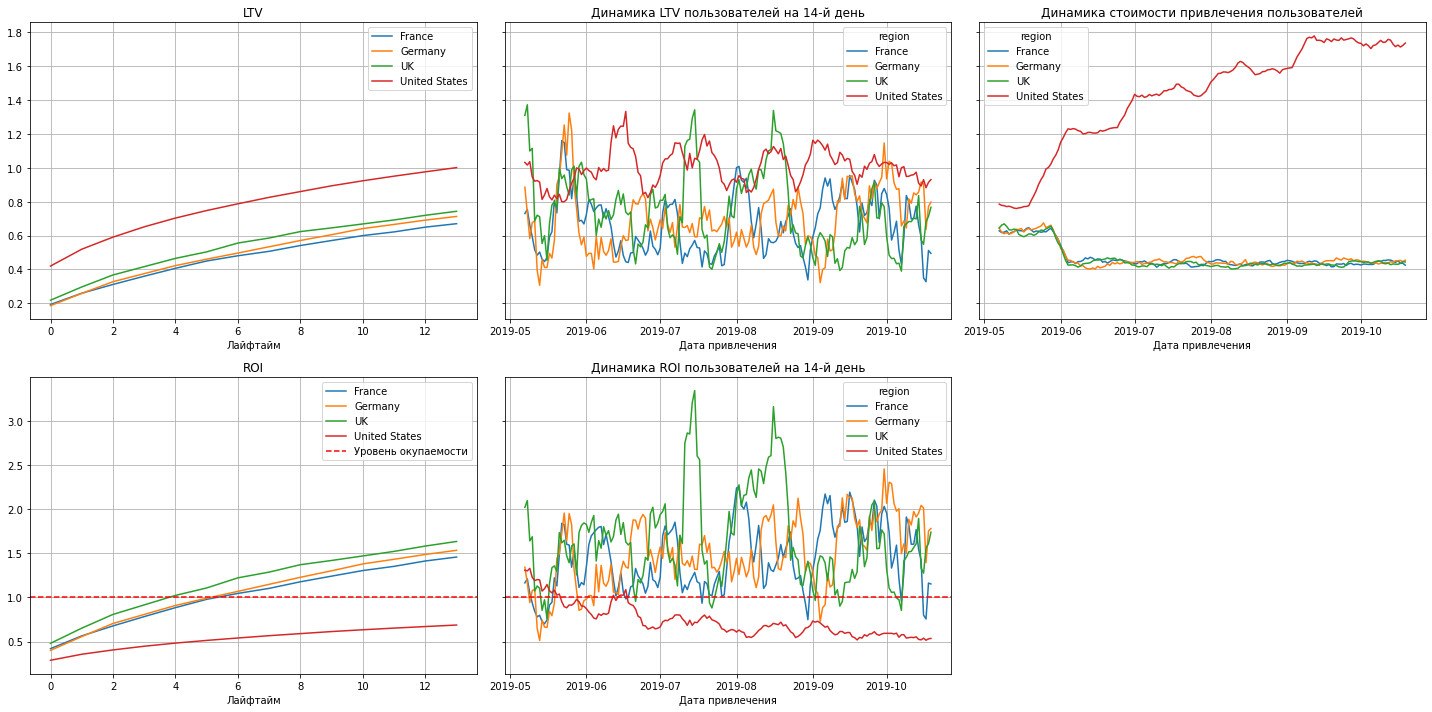

In [56]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Вывод:** Благодаря разбивке мы выявили страну, где рекламные компании не окупаются - США (ROI равен 65%). Стоит отметить, что ROI в других странах на 14 день находится на отметке в 115%. LTV показывает неплохие результаты на протяжении этих 6 месяцев в США, тогда как стоимость привлечения стремительно растет. Поэтому реклама в США окупалась только до середины мая. В других же странах наблюдается снижение стоимости привлечения пользователя в начале июне и затем держится на одной отметке.  
Именно из-за рекламных кампаний в США компания терпит убытки.

#### Окупаемость рекламы с разбивкой по рекламным каналам

In [57]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], )

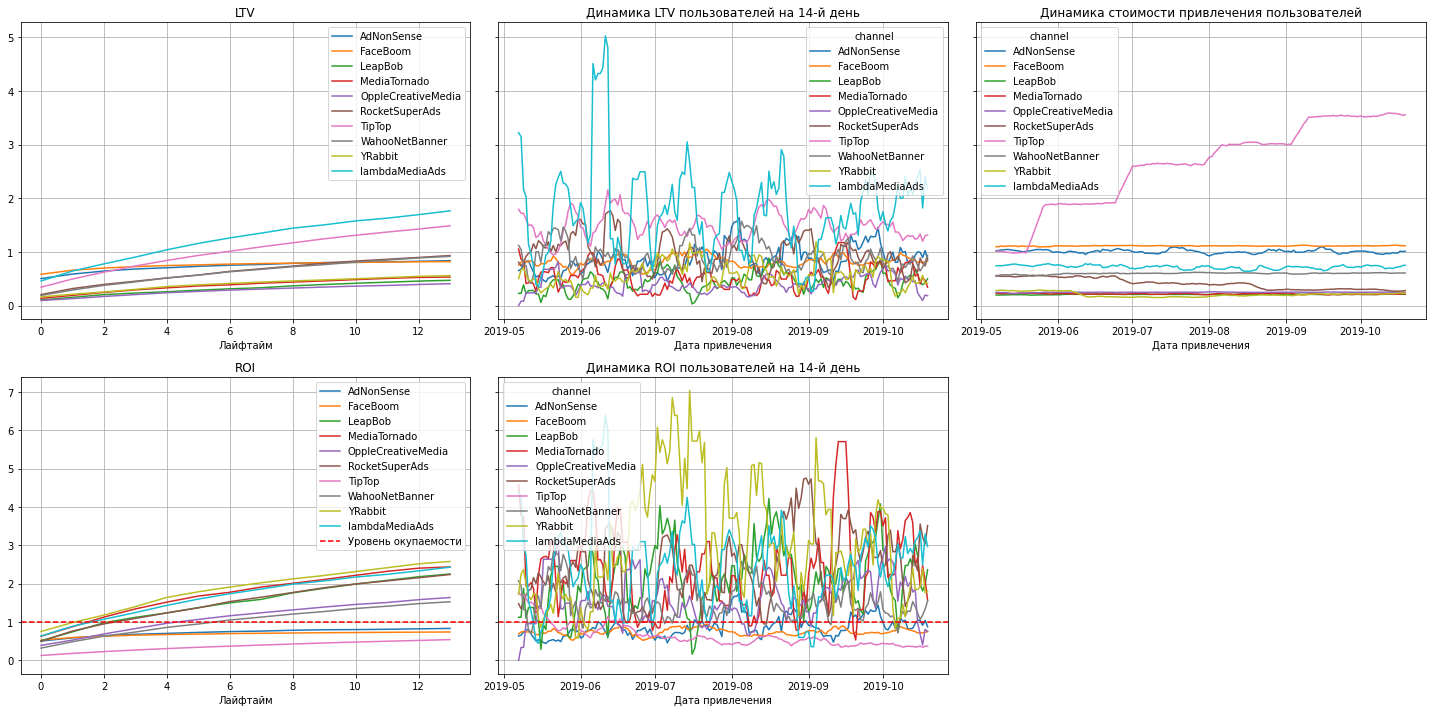

In [58]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Вывод:** Не окупаются три рекламных канала: `TipTop`, `FaceBoom`, `AdNonSense`. При этом хуже всего дела обстоят с `TipTop`, стоимость привлечения здесь намного выше, чем в других каналах, к тому же каждый месяц дорожает в среднем на 1 условную единицу.

#### Окупаемость рекламы в США

Так как именно США выбивается из всех регионов, стоит рассмотреть подробнее окупаемость в разбивке по девайсам и каналам привлечения, чтобы выявить причину неокупаемости.

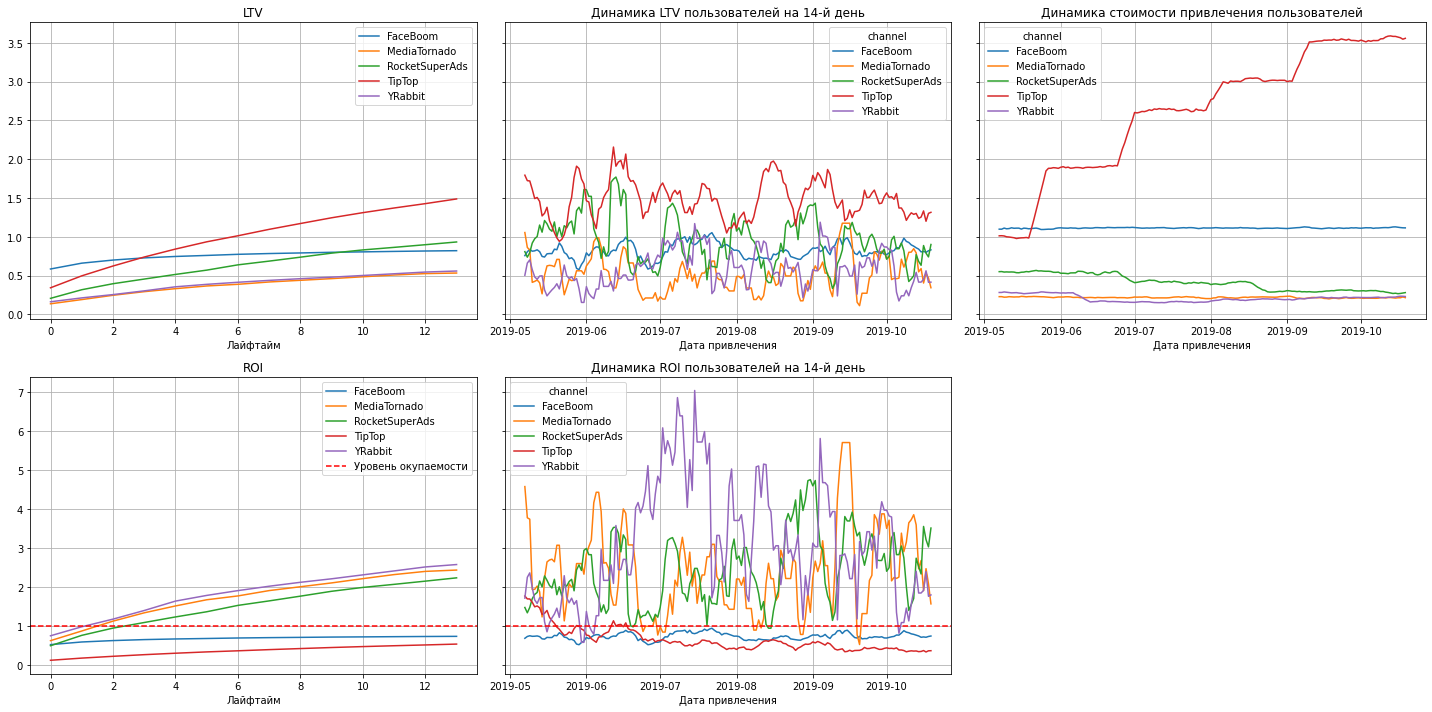

In [59]:
# Сделаем срез по США и посмотрим на lTV, ROI, CAC
# В разбивке по каналам привлечения
profiles_usa = profiles.query('region == "United States"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

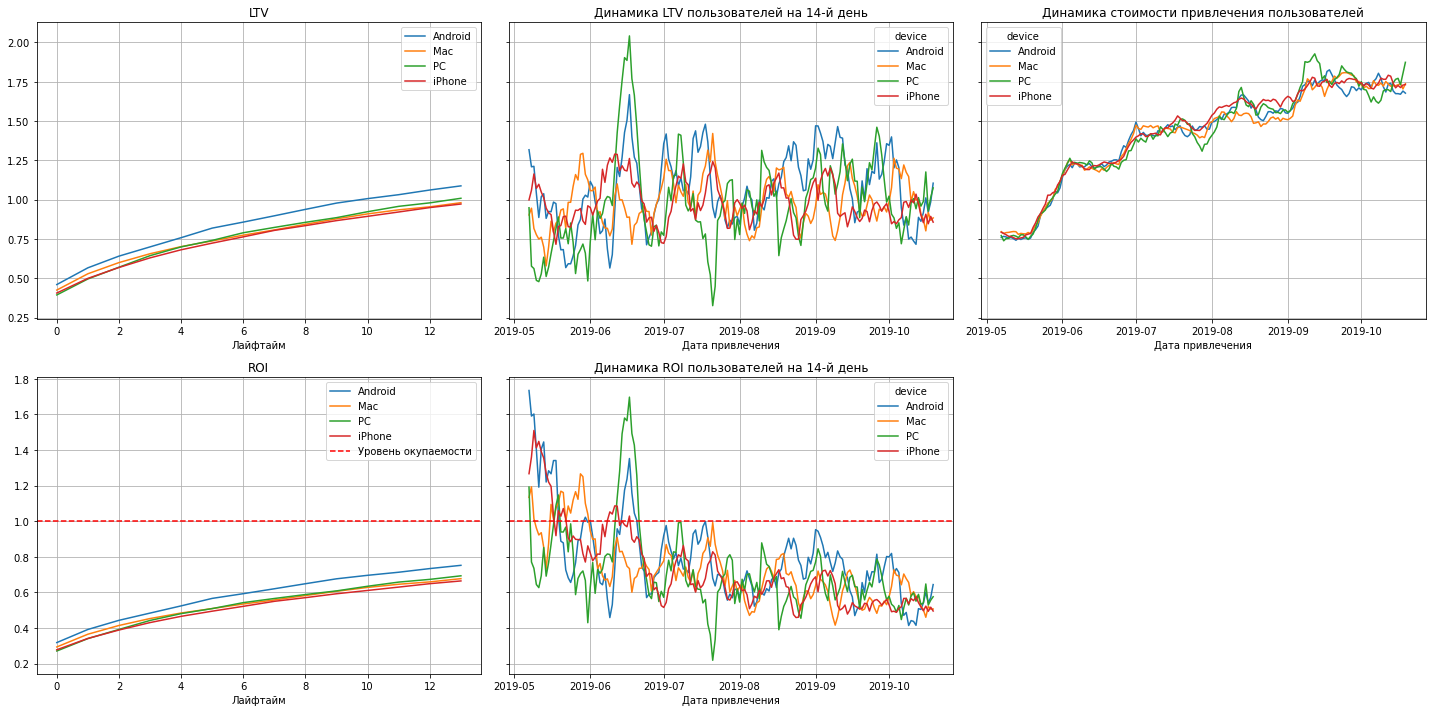

In [60]:
# В разбивке по девайсам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'], )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

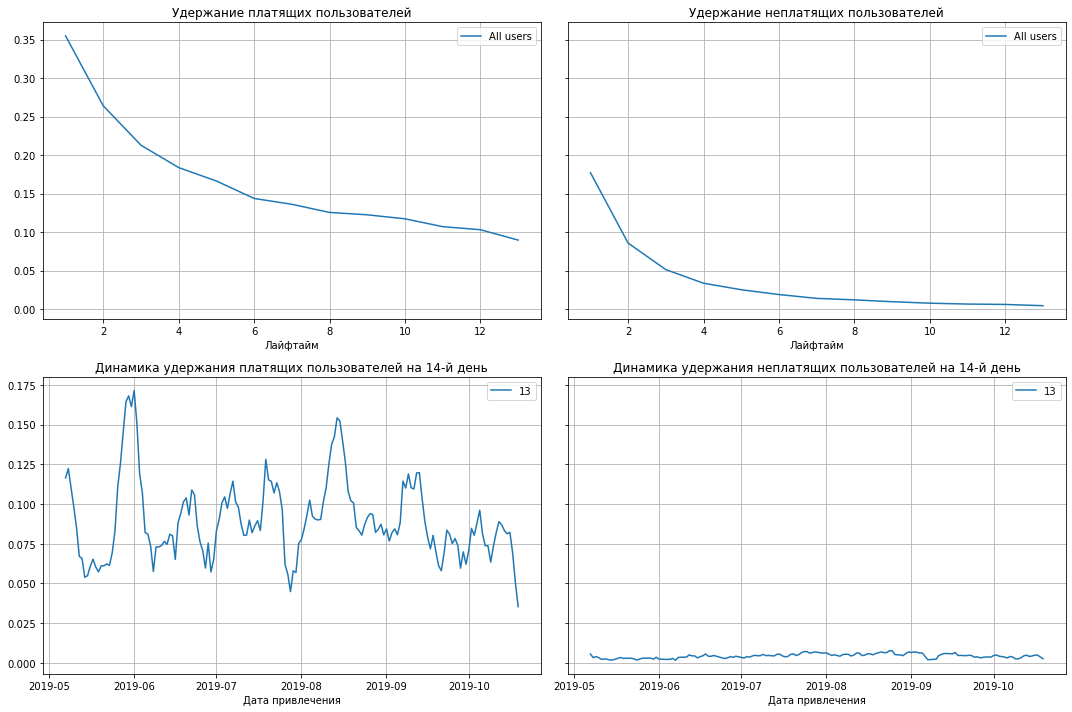

In [61]:
# Посмотрим все ли в порядке с удержанием
retention_raw, retention, retention_history = get_retention(
    profiles_usa, visits, datetime(2019, 11, 1).date(), 14,)
plot_retention(retention, retention_history, 14, window=7)

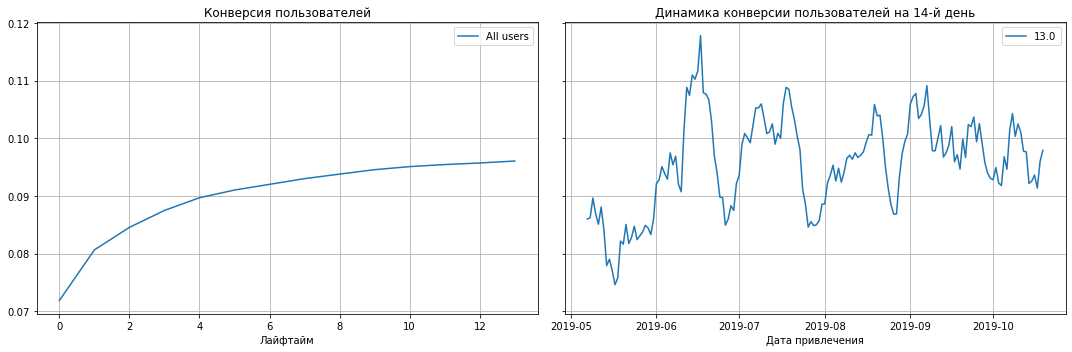

In [62]:
# Посмотрим все ли в порядке с конверсией
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_usa, orders, datetime(2019, 11, 1).date(), 14,)
plot_conversion(conversion, conversion_history, 14, window=7)

Чтобы понять особенности США, посмотрим на показатели во всем остальном мире и сравним результаты.

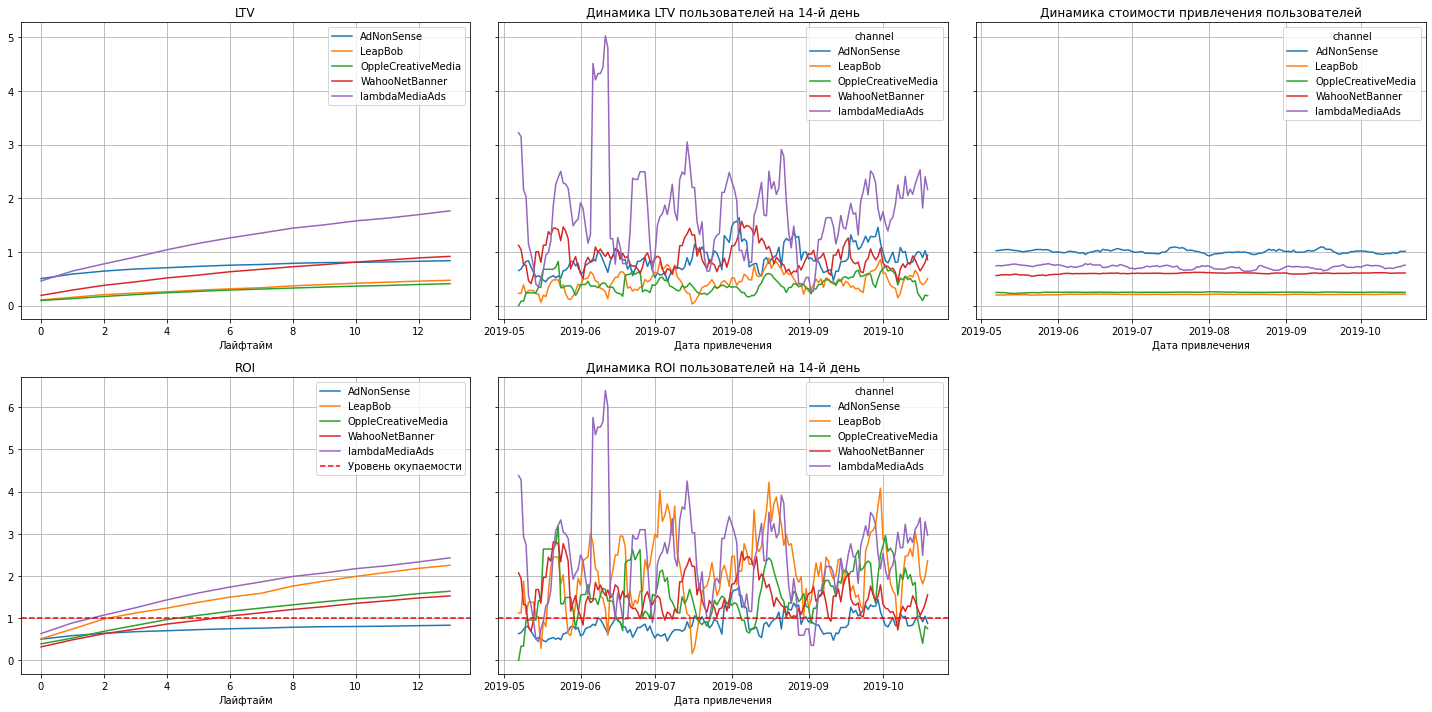

In [63]:
# Сделаем срез без США
# Разбивка по каналам
profiles_not_usa = profiles.query('region != "United States"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_not_usa, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'], )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

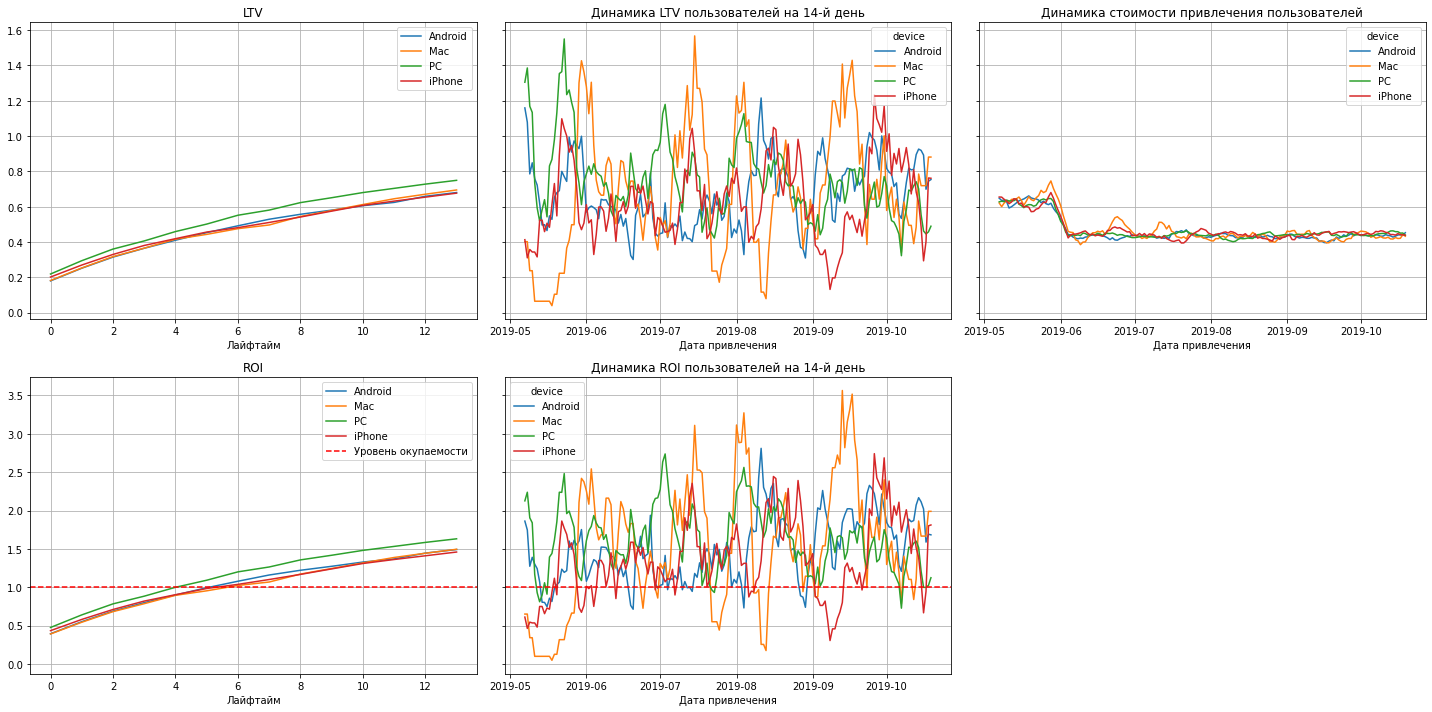

In [64]:
# Разбивка по девайсам
profiles_not_usa = profiles.query('region != "United States"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_not_usa, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'], )
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Вывод:** В результате подробного исследования окупаемости рекламы в США выявлен ряд особенностей:
1. Не окупаются такие рекламные каналы как `TipTop` и `FaceBoom`. А стоимость привлечения через канал `TipTop` растет с каждым месяцем больше чем на 1 уловную единицу. При этом стоит отметить, что данные рекламные каналы в принципе отсутствуют в других странах.
2. С удержанием и конверсией все в порядке, не наблюдается отклонений от показателей других стран.
3. В разбивке по девайсам не окупается ни один, поэтому здесь не наблюдаются какие-либо особенности США.

Проанализируем конверсию и удержание по каналам, устройствам, странам.

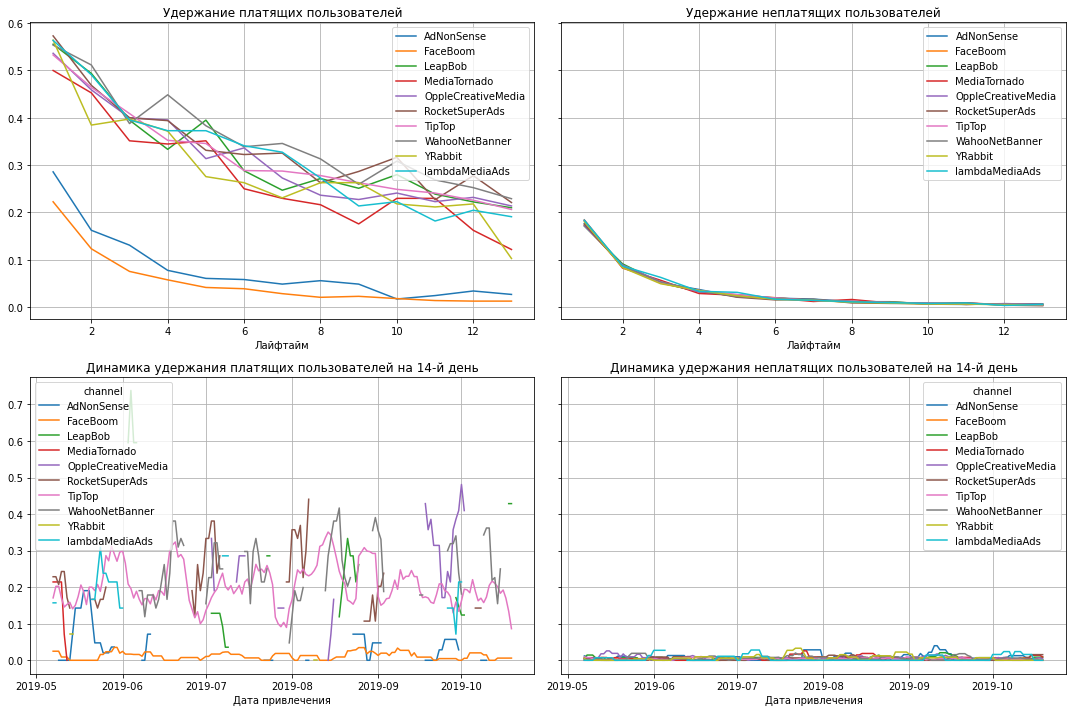

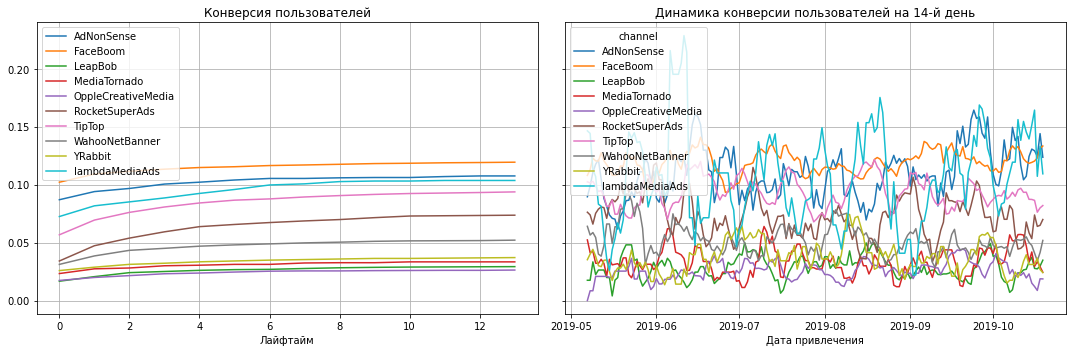

In [65]:
# По каналам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['channel'])
plot_retention(retention, retention_history, 14, window=7)
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['channel'])
plot_conversion(conversion, conversion_history, 14, window=7)

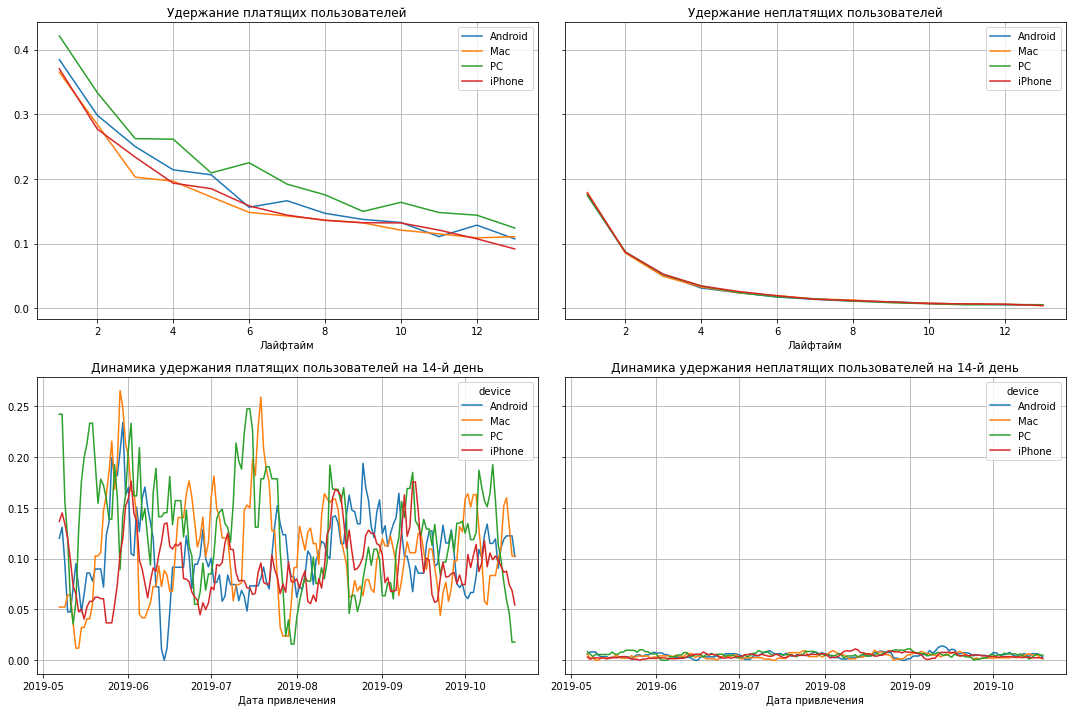

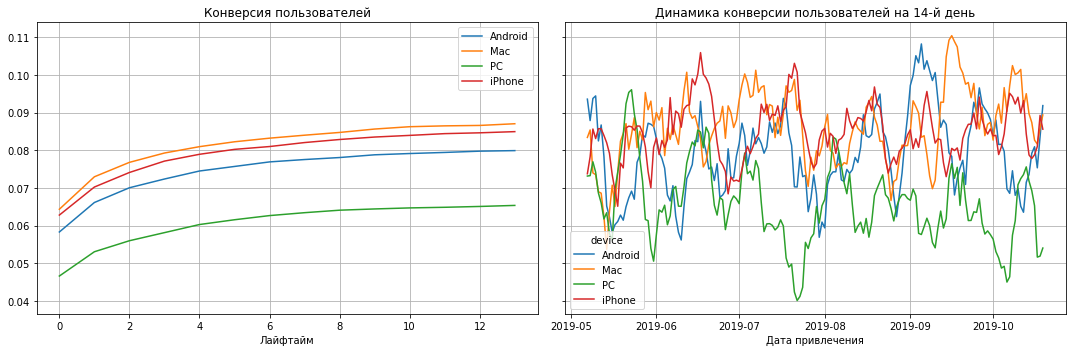

In [66]:
# По устройствам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['device'])
plot_retention(retention, retention_history, 14, window=7)
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['device'])
plot_conversion(conversion, conversion_history, 14, window=7)

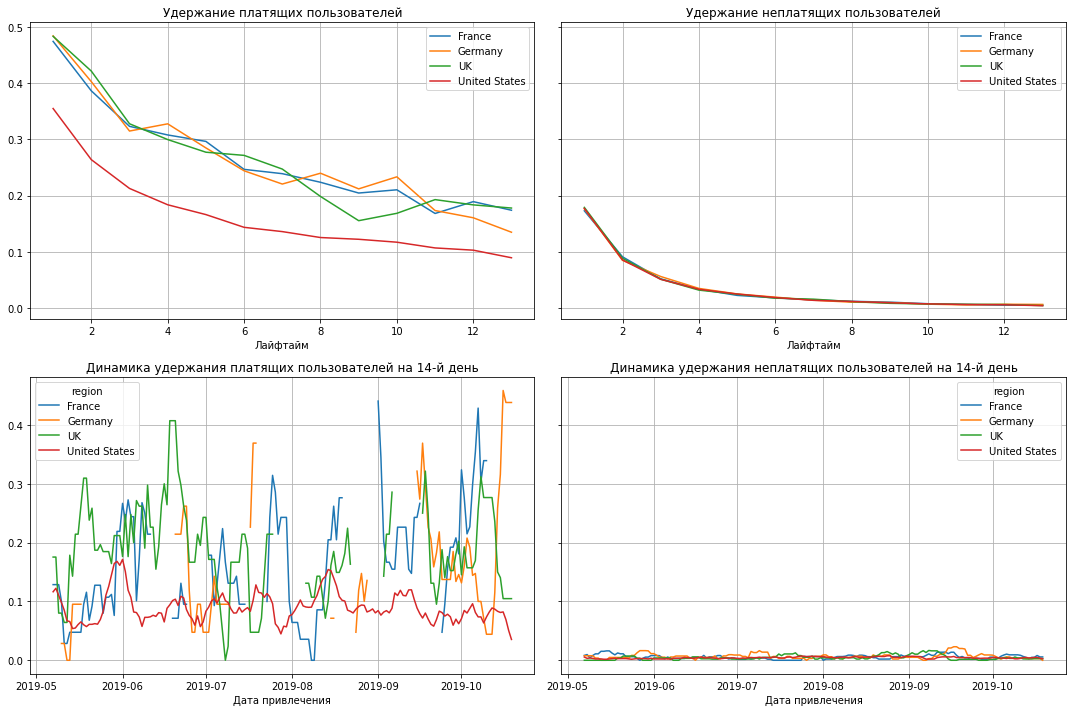

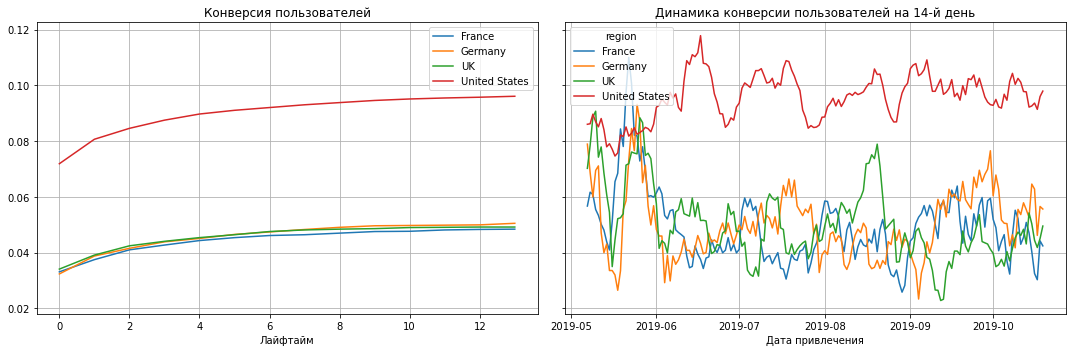

In [67]:
# По странам
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions = ['region'])
plot_retention(retention, retention_history, 14, window=7)
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions = ['region'])
plot_conversion(conversion, conversion_history, 14, window=7)

**Вывод:** Проанализировав конверсию и удержание по каналам, устройствам, странам, мы выявили ряд важных особенностей:
1. Пользователи привлеченные каналами `AdNonSense` и `Faceboom` хорошо конвертируются, но удержание у них самое низкое, платящих пользователей на 14-й день почти не остается.
2. По устройствам наблюдается более стабильная картина. Удержание у всех устройсв примерно на одном уровне, чуть выше у ПК. Но при этом самая низкая конверсия именно у ПК.
3. В США пользователи конвертируются в два раза лучше остальных стран, однако удержание тут самое низкое.

### Общие выводы

В результате проведенного исследования мы выяснили, что привлечение пользователей является абсолютно неэффектиным. Пользователи не окупаются за две недели. На 14-й день LTV составляет в среднем 80% от CAC. Удержание платящих пользователей на 14 день составило 10%, что не является критически низким показателем.
Конверсия на 14-й день составляет 8%, что также неплохой результат.  

Несмотря на то, что больше всего платящих пользователей приходит из США и это основной рынок, именно здесь реклама не окупается. Причиной неэффективности привлечения пользователей в США можно назвать канал `TipTop`. Стоимость привлечения пользователя здесь самая большая, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop'a и, соответственно, не очень высокой их платежеспособностью.  
В США необходимо обратить внимание на низкое удержание пользователей.  
Также причиной неэффективности привлечения пользователей можно назвать низкое удержание пользователей с каналов `AdNonSense` и `Faceboom`.

Рекомендации: Пересмотреть рекламную политику в США. Отказаться от канала привлечения `TipTop`. Обратить внимание на низкое удержание пользователей с каналов `AdNonSense` и `Faceboom`. Стоит меньше вкладывать в рекламные кампании через `Faceboom`. 
